In [1]:
# Date: Jan 5, 2022
# Author: Sashka Warner
# Desc: 
# -- Fetches historical air quality data from OpenWeather API,
# -- Fills gaps in air quality data based on averages for a given timestep, 
# -- Summarizes data by daily maximum values
# -- Creates and trains a Long Short-Term Memory (LSTM) model to predict future air quality

In [78]:
# Imports
import os
import re
from dotenv import load_dotenv
from datetime import datetime, timedelta
import collections
import time
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

In [3]:
# Load credentials
load_dotenv()
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')

# Create basic URL for API call
WEATHER_API_URL = 'https://api.openweathermap.org/data/2.5/air_pollution/history'

In [4]:
def get_data(lat, long, date1, date2):
    '''
    Submits request to API for air quality data filtered based on provided lat, long, start date, and end date.
    Note: Can request max 1000 API calls / day without incurring overages.

    Parameters:
    ------------
    lat: Latitude (decimal degrees)
    long: Longitude (decimal degrees)
    date1: Start date (unix time, UTC time zone), e.g. start=1606488670
    date2: End date (unix time, UTC time zone), e.g. end=1606747870

    Returns:
    ------------
    1) json data from API on successful request, OR
    2) -1 if unsuccessful request

    '''
    # Create url from params
    params = {
        'lat': lat,
        'lon': long,
        'start': date1,
        'end': date2,
        'appid': WEATHER_API_KEY,
    }
    
    try:
        response = requests.get(url=WEATHER_API_URL, params=params)
        return response.json()['list']
    except:
        return -1

In [5]:
# Specify position
site_lat = 44.026280
site_long = -123.083715

# Specify time range for filtering
d1 = datetime(2017, 1, 1)
d2 = datetime(2022, 12, 31)
# Convert to unix time for api call
d1_unix = int(time.mktime(d1.timetuple()))
d2_unix = int(time.mktime(d2.timetuple()))

# Get air quality data formatted as json based on 
# query parameters
air_quality_json = get_data(
    lat=site_lat, 
    long=-site_long, 
    date1=d1_unix, 
    date2=d2_unix)

In [6]:
# Convert air quality data to DataFrame
air_quality = pd.json_normalize(air_quality_json)
# Format time stamps
air_quality['dt'] = pd.to_datetime(air_quality['dt'], unit='s')
air_quality.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
0,2020-11-25 01:00:00,1,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


In [7]:
# Remove dots from column names
air_quality.columns = air_quality.columns.map(lambda x: re.sub('\.', '_', x))
air_quality.reset_index(drop=True, inplace=True)
air_quality.head()

,dt,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
0,2020-11-25 01:00:00,1,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


In [8]:
# Check types and NAs
for i in air_quality.columns:
    print(i, 'type:', air_quality[i].map(lambda x: type(x)).unique(), 'Has NAs:', any(air_quality[i].isna()))

dt type: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>] Has NAs: False
main_aqi type: [<class 'int'>] Has NAs: False
components_co type: [<class 'float'>] Has NAs: False
components_no type: [<class 'float'>] Has NAs: False
components_no2 type: [<class 'float'>] Has NAs: False
components_o3 type: [<class 'float'>] Has NAs: False
components_so2 type: [<class 'float'>] Has NAs: False
components_pm2_5 type: [<class 'float'>] Has NAs: False
components_pm10 type: [<class 'float'>] Has NAs: False
components_nh3 type: [<class 'float'>] Has NAs: False


In [9]:
# Examine gaps in time series
air_quality.at[1,'dt'] - air_quality.at[0, 'dt']

# Extract date time column
aq_dates = air_quality['dt']

# Create dict to store unique time deltas
unique_deltas = collections.defaultdict(int)

# Count instances of unique time deltas
for i, val in enumerate(aq_dates):
    if(i > 0):
        t_delta = aq_dates[i] - aq_dates[i-1]
        unique_deltas[t_delta] += 1
        #Examine outliers and their PM2.5 values
        if(t_delta != timedelta(hours=1)):
            print(
                't-1:', aq_dates[i-1], 'PM2.5:', air_quality.at[i-1, 'components_pm2_5'], 
                't:', aq_dates[i], 'PM2.5:', air_quality.at[i, 'components_pm2_5'])
    
unique_deltas

t-1: 2021-01-27 00:00:00 PM2.5: 3.64 t: 2021-01-28 01:00:00 PM2.5: 2.13
t-1: 2022-01-23 00:00:00 PM2.5: 51.82 t: 2022-01-24 01:00:00 PM2.5: 32.85
t-1: 2022-02-20 00:00:00 PM2.5: 1.46 t: 2022-02-21 01:00:00 PM2.5: 1.87
t-1: 2022-07-20 00:00:00 PM2.5: 9.06 t: 2022-07-22 01:00:00 PM2.5: 35.14
t-1: 2022-12-09 00:00:00 PM2.5: 6.05 t: 2022-12-11 01:00:00 PM2.5: 4.42
t-1: 2022-12-25 00:00:00 PM2.5: 3.42 t: 2022-12-26 01:00:00 PM2.5: 18.55


defaultdict(int,
            {Timedelta('0 days 01:00:00'): 18193,
             Timedelta('1 days 01:00:00'): 4,
             Timedelta('2 days 01:00:00'): 2})

In [10]:
# Create list for filled time steps
fill_steps = []

# Define variable for 1 hr difference
one_hr = timedelta(hours=1)

# Add time steps for gaps in time series
for i, val in enumerate(aq_dates):
    if(i > 0):
        # Create counter for while loop
        # if we need to gap fill the timeseries
        loop_counter = i - 1
        # Get [i-1] timestep
        last_timestep = aq_dates[i-1]
        # Get [i] timestep
        current_timestep = aq_dates[i]
        # Calculate time delta
        t_delta = current_timestep - last_timestep
        
        while(t_delta > one_hr):
            # Add one hour to the [i-1] timestep
            new_timestep = last_timestep + one_hr
            #print(f'Current timestep: {last_timestep}, Adding timestep: {new_timestep}')
            # Add the new timestep to the list
            fill_steps.append(new_timestep)
            # Calculate time delta from [i] timestep
            t_delta = aq_dates[i] - new_timestep
            #print(f't_delta: {t_delta > one_hr}')
            # Increment the counter
            loop_counter += 1
            # Store the current timestep so we can add one hour to 
            # this value if needed
            last_timestep = new_timestep

len(fill_steps)

# Check that no duplicates in time steps
#duplicates = False
#for i in collections.Counter(fill_steps):
#    if(collections.Counter(fill_steps)[i] > 1):
#        duplicates = True

#print(duplicates)
#list(map(lambda x: x if x[0] else '', collections.Counter(fill_steps)))

192

In [11]:
# Check that no duplicates in source data
#dup = False
#count_dt = collections.Counter(air_quality['dt'])
#for i in count_dt:
#    if(count_dt[i] > 1):
#        dup = True

#print(dup)

In [12]:
# Create dataframe from filled timesteps
fill_df = pd.DataFrame(data=fill_steps, columns=['dt'])

# Join new timestamps to dataframe
aq_join_fill = air_quality.merge(right=fill_df, on='dt', how='outer', suffixes=['', '_join'])

# Examine missing data after join
aq_join_fill[aq_join_fill['components_pm2_5'].isna()].head()

,dt,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
18200,2021-01-27 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18201,2021-01-27 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18202,2021-01-27 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18203,2021-01-27 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18204,2021-01-27 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Check that no duplicates in first join
#dup = False
#count_dt = collections.Counter(aq_join_fill['dt'])
#for i in count_dt:
#    if(count_dt[i] > 1):
#        dup = True

#print(dup)

In [14]:
# Create copy of dt col before setting dt index so we don't lose time data
# Create DateTime index
aq_join_fill['DateTime'] = aq_join_fill['dt']
aq_join_fill_dt = aq_join_fill.set_index('dt')
#print(aq_join_fill.head())

# Average values for each day & hour to fill in missing values in the time series
averages = aq_join_fill_dt.groupby(
    [
        aq_join_fill_dt.index.strftime('%m'), # Pad dates to avoid duplicates
        aq_join_fill_dt.index.strftime('%d'), 
        aq_join_fill_dt.index.strftime('%H')]).mean()
        
#averages.shape
#print(averages.head())
#Check if PM2.5 data has nulls after averaging
print('NAs in PM2.5 data after averaging over time: ', averages['components_pm2_5'].isna().sum())

NAs in PM2.5 data after averaging over time:  0


/var/folders/bx/8_p36bpd14nckr66rq2kk6kc0000gn/T/ipykernel_2774/1078082750.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aq_join_fill_dt.index.strftime('%H')]).mean()


In [15]:
# Prep tables for join
averages['m_d_h'] = averages.index.map(lambda x: str(x[0]) + str(x[1]) + str(x[2]))
#any(averages.duplicated(subset=['m_d_h']))
aq_join_fill_dt['m_d_h'] = aq_join_fill_dt.index.map(lambda x: x.strftime('%m') + x.strftime('%d') + x.strftime('%H'))
averages.head()
#aq_join_fill_dt.head()

main_aqi  components_co  components_no  components_no2  \
dt dt dt                                                           
01 01 00       1.5        363.825          0.010          12.040   
      01       1.5        367.165          0.485          11.225   
      02       2.0        365.495          1.380          10.455   
      03       2.0        378.850          2.245          12.210   
      04       2.0        437.260          5.655          15.060   

          components_o3  components_so2  components_pm2_5  components_pm10  \
dt dt dt                                                                     
01 01 00         52.570           6.695            11.065           14.460   
      01         53.640           6.500            11.760           15.430   
      02         55.075           7.315            11.615           15.565   
      03         54.005          11.965            12.535           17.165   
      04         61.870          28.610            13.110           18.350   

          components_nh3   m_d_h  
dt dt dt                          
01 01 00          16.020  010100  
      01          16.025  010101  
      02          15.960  010102  
      03          15.830  010103  
      04          10.260  010104

In [16]:
# Join averages to time series
#print(aq_join_fill_dt.shape)
aq_averaged = aq_join_fill_dt.merge(right=averages, how='left', on = 'm_d_h', suffixes= ('', '_avg'))
#aq_averaged.reset_index(drop=True, inplace=True)
# Check duplicates
print(f'Has duplicate dates? {any(aq_averaged["DateTime"].duplicated())}')

# Check which dates have missing data
missing_data = aq_averaged[aq_averaged['components_co'].isna()]['DateTime'].to_list() 
print(f'Null dates match initial gap filling? {missing_data == fill_steps}\n# Missing records: {len(missing_data)}')

Has duplicate dates? False
Null dates match initial gap filling? True
# Missing records: 192


In [17]:
# Compile original data column names
data_cols = [
    'main_aqi',
    'components_co', 
    'components_no', 
    'components_no2',
    'components_o3',
    'components_so2',
    'components_pm2_5',
    'components_pm10',
    'components_nh3']

# Update missing values with joined data
for col_name in data_cols:
    aq_averaged[col_name] = aq_averaged[col_name].where(aq_averaged[col_name].notnull(), aq_averaged[col_name + '_avg'])


# Check that all NAs have been removed from PM2pt5 data
print(f'Number of missing records: {aq_averaged["components_pm2_5"].isna().sum()}')

Number of missing records: 0


In [18]:
# Extract only columns of interest
data_cols.insert(0, 'DateTime')
aq_averaged = aq_averaged[data_cols]
aq_averaged.head()

,DateTime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3
0,2020-11-25 01:00:00,1.0,236.99,0.60,3.56,66.52,1.97,7.08,8.78,17.73
1,2020-11-25 02:00:00,1.0,233.65,0.92,2.87,65.80,1.91,6.16,7.67,16.97
2,2020-11-25 03:00:00,1.0,223.64,0.91,2.16,63.66,1.62,4.53,5.74,13.81
3,2020-11-25 04:00:00,1.0,213.62,0.64,1.54,67.23,2.71,2.81,3.43,6.02
4,2020-11-25 05:00:00,1.0,210.29,0.60,1.56,69.38,3.58,2.30,2.70,3.33


<AxesSubplot: xlabel='year_month', ylabel='components_pm2_5'>

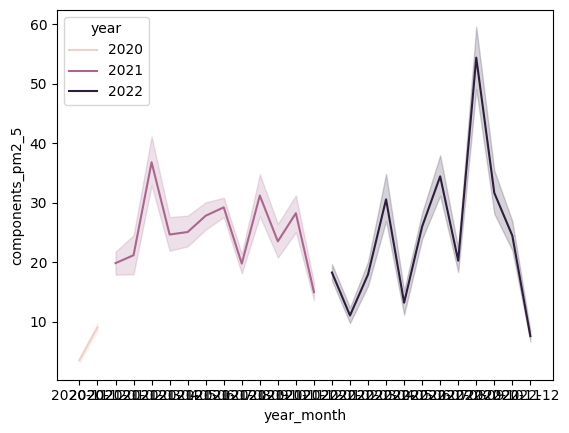

In [69]:
# Plot data over time
aq_by_month = aq_averaged.copy()
aq_by_month['year'] = aq_by_month['DateTime'].map(lambda x: x.year)
aq_by_month['month'] = aq_by_month['DateTime'].map(lambda x: x.month)
aq_by_month['year_month'] = aq_by_month['DateTime'].map(lambda x: x.strftime('%Y-%m'))
aq_by_month.head()
sns.lineplot(x='year_month', y='components_pm2_5', hue='year', data=aq_by_month)

<AxesSubplot: xlabel='month', ylabel='components_pm2_5'>

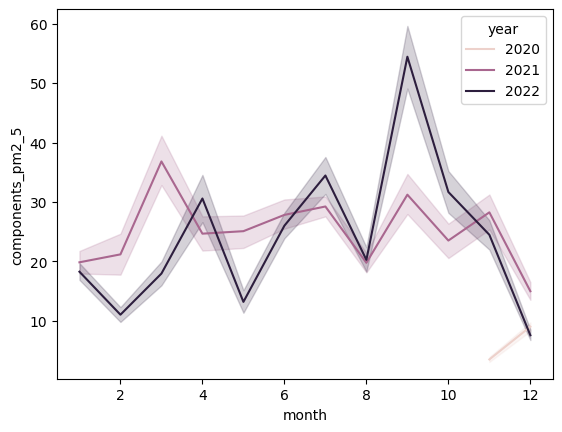

In [70]:
# Plot by month:
# Note that: for the two years of data, fire season seems to have had worst monthly air quality for the second year
# Potential increasing trend as well as seasonabl trend
sns.lineplot(x='month', y='components_pm2_5', hue='year', data=aq_by_month)

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_lag1'>

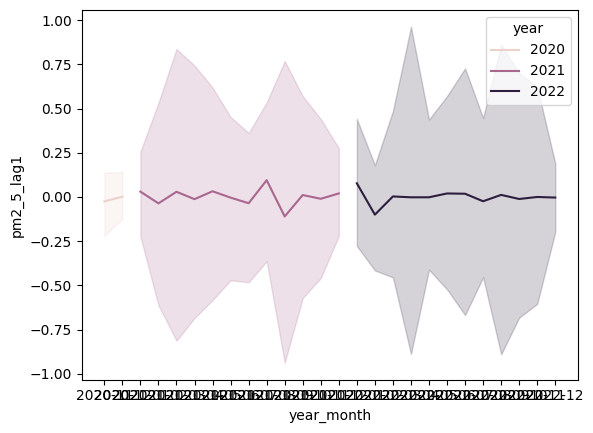

In [71]:
# Transform time series to stationary:
# Create a differenced series to remove any increasing trend
def difference(dataset, interval=1):
    diff = [None] * interval # Start with null value(s) so length matches the other data frames
    # Iterate through 1 - n records
    for i in range(interval, len(dataset)):
        # Calculate difference between current and timestep and past timestep
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return pd.Series(diff)

aq_differenced = difference(dataset=aq_by_month['components_pm2_5'])

# Add the differenced data back to the original data frame
aq_by_month['pm2_5_lag1'] = aq_differenced

# Plot the differenced data over time
sns.lineplot(x=aq_by_month['year_month'], y=aq_by_month['pm2_5_lag1'], hue=aq_by_month['year'])

<AxesSubplot: xlabel='month', ylabel='pm2_5_lag1'>

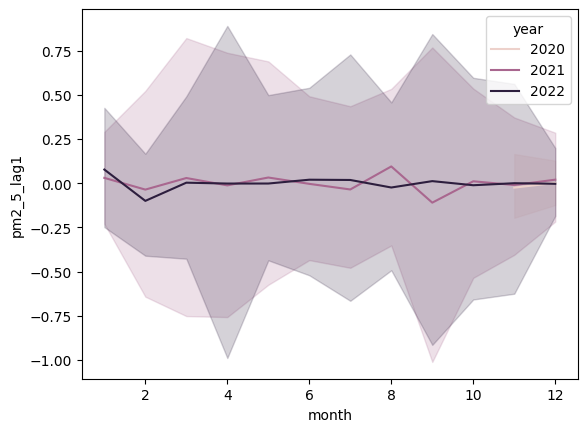

In [72]:
#Plot the differenced data by month
# There are still some seasonal variations, but there isn't enough data 
# to seasonally differenc the whole
sns.lineplot(x=aq_by_month['month'], y=aq_by_month['pm2_5_lag1'], hue=aq_by_month['year'])

<AxesSubplot: xlabel='year_month', ylabel='pm2_5_lag1_lagYr'>

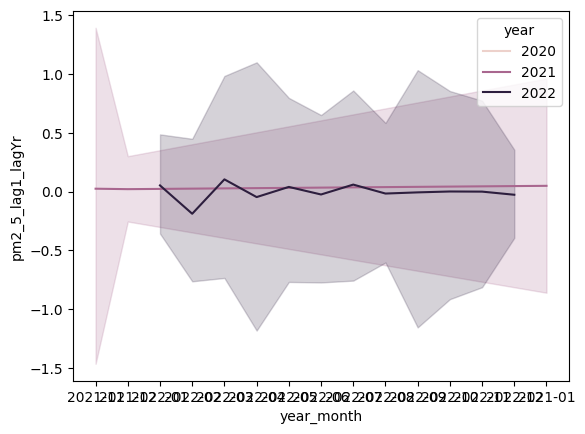

In [74]:
# (Transforming data to stationary cont'd)
# 2. Apply seasonal lag to remove variations due to winter and summer (eg fire season)
aq_differenced_1year = difference(dataset=aq_by_month['pm2_5_lag1'], interval = 365*24)

# Add the differenced data back to the original data frame
aq_by_month['pm2_5_lag1_lagYr'] = aq_differenced_1year

# Plot the differenced data over time
# Removes some of the variation but does not appear to make a substantial difference
# For now, we will proceed with the first differenced data of lag=1
sns.lineplot(x=aq_by_month['year_month'].iloc[365*24:], y=aq_by_month['pm2_5_lag1_lagYr'].iloc[365*24:], hue=aq_by_month['year'])

In [119]:
# Frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    # Shift current values by lag value (eg shift forward one timestep)
    columns = [df.shift(i) for i in range(1, lag+1)]
    # Add the shifted records to the bottom of the original timeseries
    columns.append(df)
    # Concatenate the shifted records with the original timeseries side by side,
    # but shifted forward by the given timestep
    # Eg
    # Col1  Col2
    # T     T+1
    # T+1   T+2 etc
    df = pd.concat(columns, axis=1)
    # Remove the first row of nulls 
    # (because both time series have a missing first record)
    df = df.drop(0)
    return df

array([[   nan, -0.92 ],
       [-0.92 , -1.63 ],
       [-1.63 , -1.72 ],
       ...,
       [ 2.2  ,  3.245],
       [ 3.245,  2.88 ],
       [ 2.88 ,  2.03 ]])

In [170]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train (possibly not needed for 1d timeseries)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [171]:
# Evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
        # report performance
        rmse = np.sqrt(np.mean_squared_error(raw_data[1:], predictions))
    return rmse

In [194]:
# Fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print(X.shape)
    # prepare model
    model = Sequential()
    # batch_input_shape = (numberOfSequence, timesteps, data shape) (deprecated
    # )
    #model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    #model.add(LSTM(neurons, batch_size=batch_size, X.shape[1], shape=X.shape[2], stateful=True))
    model.add(LSTM(neurons, activation='relu', input_shape=(X.shape[1], X.shape[2])))


    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #for i in range(nb_epoch):
    #    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #    model.reset_states()
    #    # evaluate model on train data
    #    raw_train = raw[-(len(train)+len(test)+1):-len(test)]
    #   train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
    #    model.reset_states()
        # evaluate model on test data
    #    raw_test = raw[-(len(test)+1):]
    #    test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    #    model.reset_states()
    #    history = pd.DataFrame()
    #    history['train'], history['test'] = train_rmse, test_rmse
    #return history

In [195]:
#Define train split
train_split = 0.8 # For 80/20 test/train split

# run diagnostic experiments
def run():
    # load dataset
    series = aq_by_month['components_pm2_5']
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train_n = int(len(supervised_values) * train_split) - 1
    train, test = supervised_values[0:train_n], supervised_values[train_n + 1:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 1
    fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    # run diagnostic tests
    #for i in range(repeats):
    #    history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    #    plt.plot(history['train'], color='blue')
    #    plt.plot(history['test'], color='orange')
    #    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    #    plt.savefig(f'model_runs/epochs_diagnostic_{i}.png')

run()

(14709, 1, 1)


In [ ]:
# Save the model
#joblib_file = "LSTM_model.joblib"
#joblib.dump(model, joblib_file) 